# Constructing and training a convolutional neural network with human-like performance (>98%) on MNIST

Python notebook can be found at [https://github.com/sempwn/keras-intro](https://github.com/sempwn/keras-intro)

Before starting we'll need to make sure tensorflow and keras are installed. Open a terminal and type the following commands:
```sh
pip install --user tensorflow
pip install --user keras
```

The back-end of keras can either use theano or tensorflow. Verify that keras will use tensorflow by using the following command:

```sh
sed -i 's/theano/tensorflow/g' $HOME/.keras/keras.json
```

In [1]:
%pylab inline
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Convolutional neural networks : A very brief introduction
To quote wikipedia:
> Convolutional neural networks are biologically inspired variants of multilayer perceptrons, designed to emulate the behaviour of a visual cortex. These models mitigate the challenges posed by the MLP architecture by exploiting the strong spatially local correlation present in natural images.

One principle in ML is to create a feature map for data and then use your favourite classifier on those features. For image data this might be presence of straight, curved lines, placement of holes etc. This would be very problem dependent. Instead of having to feature engineer for each specific problem, it would be better to automatically generate the feature map and combine with the classifer. CNNs are a way to achieve this.

![image](http://cs231n.github.io/assets/cnn/depthcol.jpeg)
## Automatic feature engineering
Filters or convolution kernels can be treated like automatic feature detectors. A number of filters can be set before hand. For each filter, a convolution with this and part of the input is done striding across the whole of the data. Weights for each filter are shared. The end result is a multi-dimensional matrix of copies of the original data with each filter applied to it.
![image2](http://cs231n.github.io/assets/nn1/neuron_model.jpeg)
For a classification task, after one or more convolutional layers a fully connected layer is applied. Final layers with outputs equal to the number of classes can then be added.

## Pooling
Once convolutions have been performed across the whole image, we need someway of down-sampling. Easiest and 
most common way is to perform max pooling. Over a certain size return the maximum from the outputs.
![max pooling](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

In [32]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Convolutions on image

Let's get some insight into what a random filter applied to a test image does. We'll compare this to the trained filters at the end

Each value in result is $C_i = \sum_j{I_{i+j-k} W_j}$, where $W$ is the weights kernel, $j$ is the 2D spatial index over $W$, $I$ is the input and $k$ is the coordinate of the center of $W$, specified by origin in the input parameters.

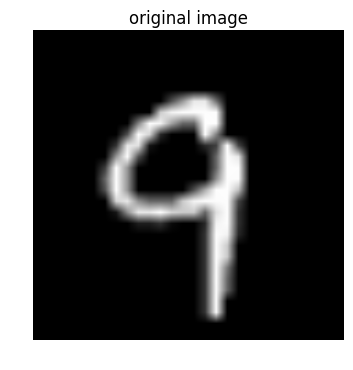

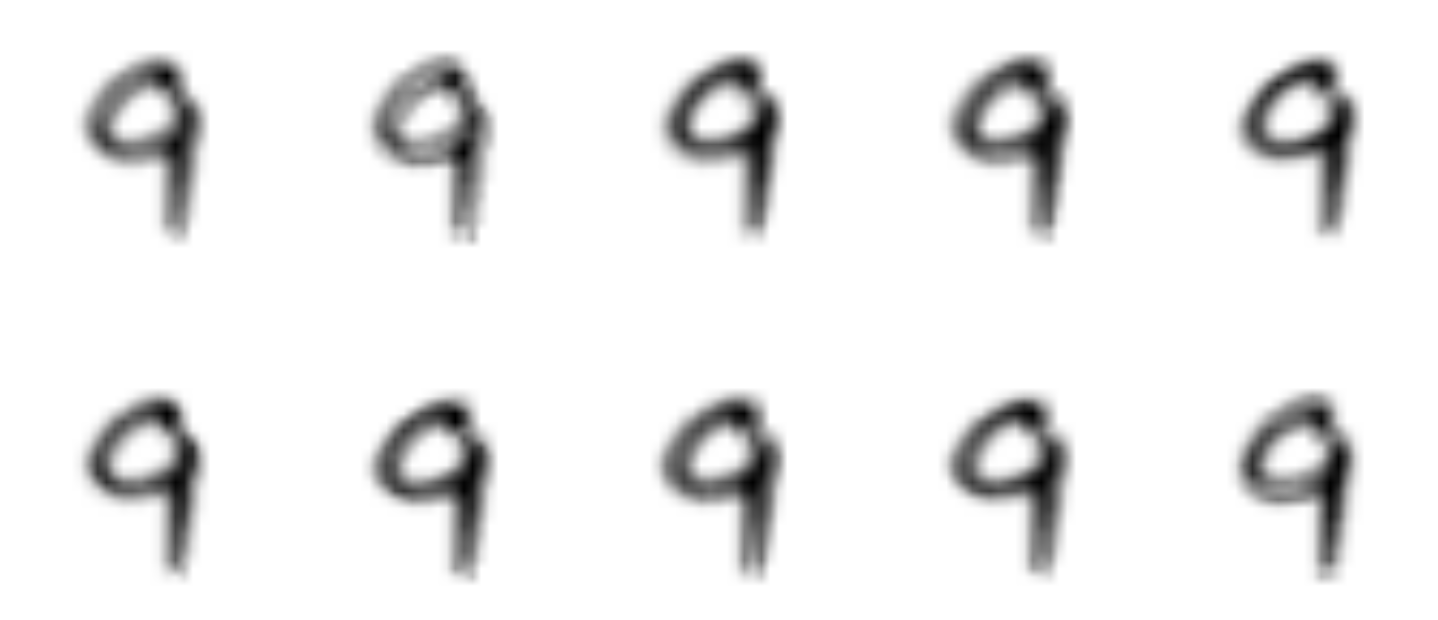

In [41]:
from scipy import signal
i = np.random.randint(X_train.shape[0])



c = X_train[i,:,:]
plt.imshow(c,cmap='gray'); plt.axis('off');
plt.title('original image');
plt.figure(figsize=(18,8))
for i in range(10):
    k = -1.0 + 1.0*np.random.rand(3,3)
    c_digit = signal.convolve2d(c, k, boundary='symm', mode='same');
    plt.subplot(2,5,i+1);
    plt.imshow(c_digit,cmap='gray'); plt.axis('off');



# Keras introduction
> Keras is a high-level neural networks API, written in Python and capable of running on top of either [TensorFlow](https://www.tensorflow.org) or [Theano](http://deeplearning.net/software/theano/). It was developed with a focus on enabling fast experimentation. 
> Being able to go from idea to result with the least possible delay is key to doing good research.

If you've used [scikit-learn](http://scikit-learn.org/stable/) then you should be on familiar ground as the library was developed with a similar philosophy.

 * Can use either theano or tensorflow as a back-end. For the most part, you just need to set it up and then interact with it using keras. Ordering of dimensions can be different though.
 * Models can be instaniated using the `Sequential()` class. 
 * Neural networks are built up from bottom layer to top using the `add()` method.
 * Lots of recipes to follow and many [examples](https://github.com/fchollet/keras/tree/master/examples) for problems in NLP and image classification.

In [23]:
batch_size = 128
nb_classes = 10
nb_epoch = 6

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

if K.image_dim_ordering() == 'th': #if using theano
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: #if using tensorflow
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

#sub-sample of test data to improve training speed. Comment out 
#if you want to train on full dataset.
X_train = X_train[:10000,:,:,:]
y_train = y_train[:10000]


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

('X_train shape:', (10000, 1, 28, 28))
(10000, 'train samples')
(10000, 'test samples')


## One more trick to avoid overfitting
60000 data-points isn't a huge amount for the size of the models we're considering. 
* One trick to avoid overfitting is to use [drop-out](http://jmlr.org/papers/v15/srivastava14a.html). This is where a weight is randomly assigned zero with a given probability to avoid the model becoming too dependent on a small number of weights. 
* We can also consider [ridge](https://en.wikipedia.org/wiki/Tikhonov_regularization) or [LASSO](https://en.wikipedia.org/wiki/Lasso_%28statistics%29) regularisation as a way of trimming down the dependency and effective number of parameters.
* [Early stopping](https://en.wikipedia.org/wiki/Early_stopping) and [Batch Normalisation](https://arxiv.org/abs/1502.03167) are other strategies to help control over-fitting.

In [19]:
#Create sequential convolutional multi-layer perceptron with max pooling and dropout
model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
#model.add(Activation('relu')) #commented out this layer to speed up learning. 
#model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1])) #commented out this layer to speed up learning.
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
#model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Dense(128))
#model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [20]:
#Let's see what we've constructed layer by layer
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_4 (Convolution2D)  (None, 32, 26, 26)    320         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
activation_8 (Activation)        (None, 32, 26, 26)    0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 32, 13, 13)    0           activation_8[0][0]               
____________________________________________________________________________________________________
flatten_4 (Flatten)              (None, 5408)          0           maxpooling2d_4[0][0]             
___________________________________________________________________________________________

In [24]:
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 10000 samples, validate on 10000 samples
Epoch 1/6
10000/10000 [==============================] - 37s - loss: 1.2130 - acc: 0.6866 - val_loss: 0.5352 - val_acc: 0.8484
Epoch 2/6
10000/10000 [==============================] - 40s - loss: 0.4576 - acc: 0.8712 - val_loss: 0.4064 - val_acc: 0.8846
Epoch 3/6
10000/10000 [==============================] - 37s - loss: 0.3812 - acc: 0.8858 - val_loss: 0.3411 - val_acc: 0.9051
Epoch 4/6
10000/10000 [==============================] - 37s - loss: 0.3477 - acc: 0.9007 - val_loss: 0.3167 - val_acc: 0.9117
Epoch 5/6
10000/10000 [==============================] - 39s - loss: 0.3327 - acc: 0.9031 - val_loss: 0.3021 - val_acc: 0.9153
Epoch 6/6
10000/10000 [==============================] - 37s - loss: 0.3167 - acc: 0.9067 - val_loss: 0.2882 - val_acc: 0.9199
('Test score:', 0.28819559369683267)
('Test accuracy:', 0.91990000000000005)


# Results
Let's take a random digit example to find out how confident the model is at classifying the correct category

1/1 [==============================] - 0s


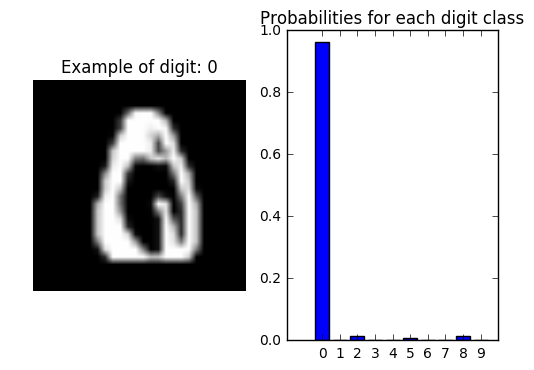

In [25]:
#choose a random data from test set and show probabilities for each class.
i = np.random.randint(0,len(X_test))
digit = X_test[i].reshape(28,28)

plt.figure();
plt.subplot(1,2,1);
plt.title('Example of digit: {}'.format(y_test[i]));
plt.imshow(digit,cmap='gray'); plt.axis('off');
probs = model.predict_proba(digit.reshape(1,1,28,28),batch_size=1)
plt.subplot(1,2,2);
plt.title('Probabilities for each digit class');
plt.bar(np.arange(10),probs.reshape(10),align='center'); plt.xticks(np.arange(10),np.arange(10).astype(str));

## Wrong predictions
Let's look more closely at the predictions on the test data that weren't correct

In [26]:
predictions = model.predict_classes(X_test, batch_size=32, verbose=1)

10000/10000 [==============================] - 14s    


In [27]:
inds = np.arange(len(predictions))
wrong_results = inds[y_test!=predictions]

1/1 [==============================] - 0s


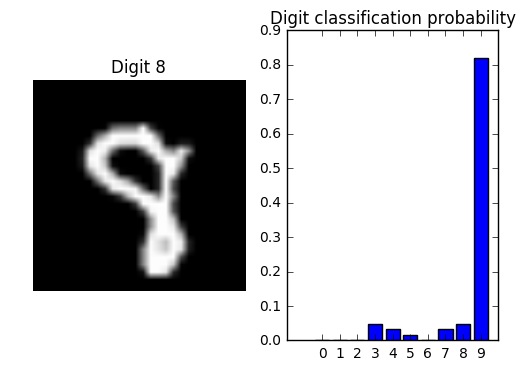

In [28]:
#choose a random wrong result from the test set
i = np.random.randint(0,len(wrong_results))
i = wrong_results[i]
digit = X_test[i].reshape(28,28)

plt.figure();

plt.subplot(1,2,1);
plt.title('Digit {}'.format(y_test[i]));
plt.imshow(digit,cmap='gray'); plt.axis('off');
probs = model.predict_proba(digit.reshape(1,1,28,28),batch_size=1)
plt.subplot(1,2,2);
plt.title('Digit classification probability');
plt.bar(np.arange(10),probs.reshape(10),align='center'); plt.xticks(np.arange(10),np.arange(10).astype(str));

It seems like for the example digit the prediction is a lot less confident when it's wrong. Is this always the case? Let's 
look at this by examining the maximum probability in any category for all digits that are incorrectly labelled.

In [29]:
prediction_probs = model.predict_proba(X_test, batch_size=32, verbose=1)

10000/10000 [==============================] - 14s    


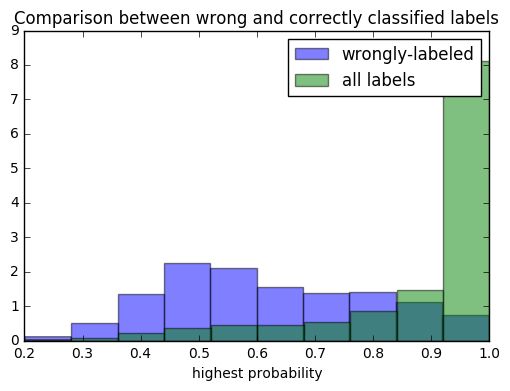

In [30]:
wrong_probs = np.array([prediction_probs[ind][digit] for ind,digit in zip(wrong_results,predictions[wrong_results])])
all_probs =  np.array([prediction_probs[ind][digit] for ind,digit in zip(np.arange(len(predictions)),predictions)])
#plot as histogram
plt.hist(wrong_probs,alpha=0.5,normed=True,label='wrongly-labeled');
plt.hist(all_probs,alpha=0.5,normed=True,label='all labels');
plt.legend();
plt.title('Comparison between wrong and correctly classified labels');
plt.xlabel('highest probability');

## What's been fitted ?
Let's look at the convolutional layer and the kernels that have been learnt.

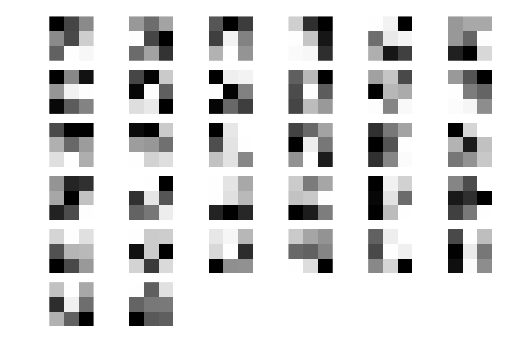

In [31]:
for i,arr in enumerate(model.layers[0].get_weights()[0]):
    plt.subplot(6,6,i+1)
    plt.imshow(arr[0,:,:],cmap='gray',interpolation='none'); plt.axis('off');

## Visualising intermediate layers in the CNN
In order to visualise the activations half-way through the CNN and have some sense of what these convolutional kernels do to the input we need to create a new model with the same structure as before, but with the final layers missing. We then give it the weights it had previously and then predict on a given input. We now have a model that gives provides us as output the convolved input passed through the activation for each of the learnt filters (32 all together).

In [42]:
#Create new sequential model, same as before but just keep the convolutional layer. 
model_new = Sequential()

model_new.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
model_new.add(Activation('relu'))

In [45]:
#set weights for new model from weights trained on MNIST.
for i in range(2):
    model_new.layers[i].set_weights(model.layers[i].get_weights())

In [55]:
#pick a random digit and "predict" on this digit (output will be first layer of CNN)
i = np.random.randint(0,len(X_test))
digit = X_test[i].reshape(1,1,28,28)
pred = model_new.predict(digit)

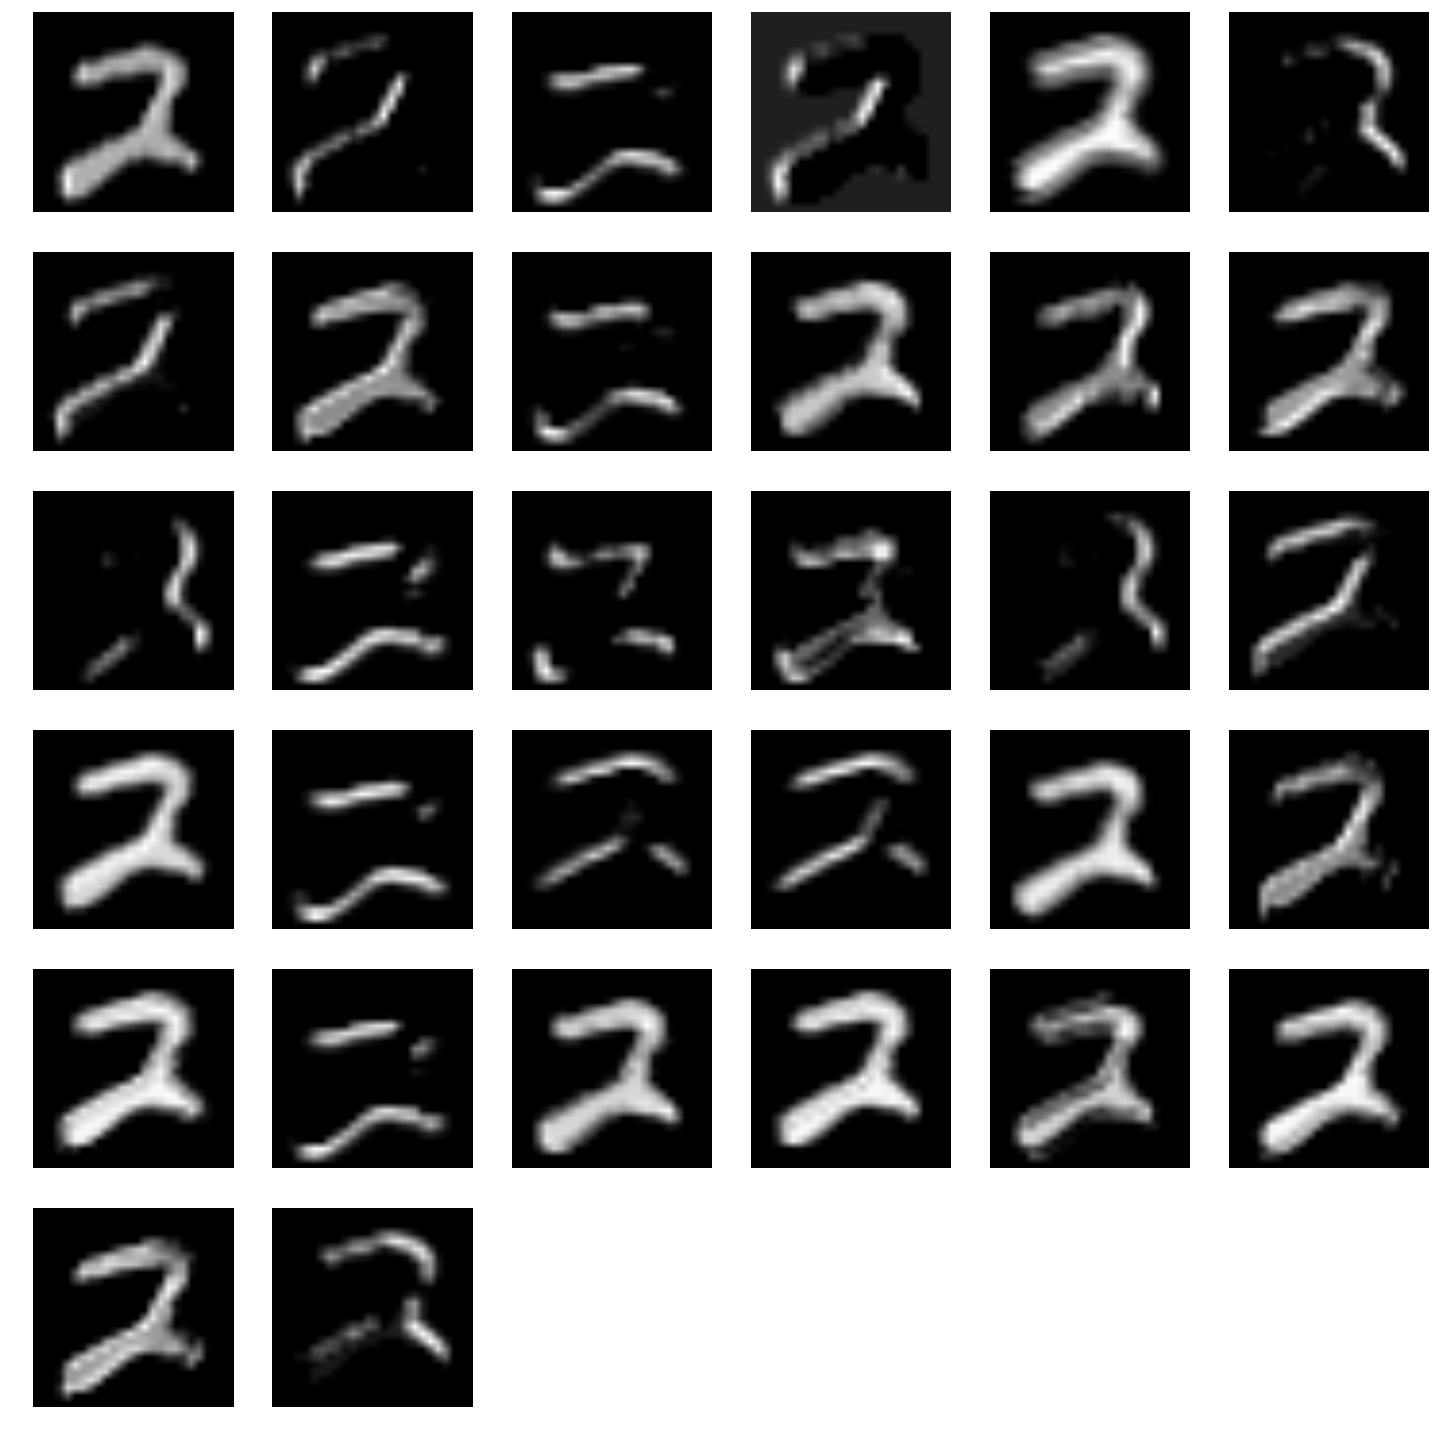

In [58]:
#For all the filters, plot the output of the input
plt.figure(figsize=(18,18))
filts = pred[0]
for i,fil in enumerate(filts):
    plt.subplot(6,6,i+1)
    plt.imshow(fil.reshape(26,26),cmap='gray'); plt.axis('off');